<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, json, requests
from pprint import pprint

param = { "format": "geojson", "starttime": "2024-03-10","limit": 20000, "endtime": "2024-05-30"}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

pprint(data)

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    Latitude = feature['geometry']['coordinates'][1]
    Longitude = feature['geometry']['coordinates'][0]
    print(f"Mag: {feature['properties']['mag']},   Place: {feature['properties']['place']},   Time: {datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)},   Lat: {Latitude},   Long: {Longitude}")

In [ ]:
import datetime, json, requests
from pprint import pprint
import pyproj

param = { "format": "geojson", "starttime": "2024-03-14","limit": 20000, "endtime": "2024-06-15", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

count = 0
earthquake_data = []

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    count += 1

    time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)

    earthquake_data.append({
      "Mag": feature['properties']['mag'],
      "Place": feature['properties']['place'],
      "Time": time,
      "Lat": feature['geometry']['coordinates'][1],
      "Long": feature['geometry']['coordinates'][0],
      "Depth": depth
    })

pprint(earthquake_data)
pprint(f"Count: {count}")

In [3]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pyproj

file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])

display(fracking_df[['JobStartDate','JobEndDate']])


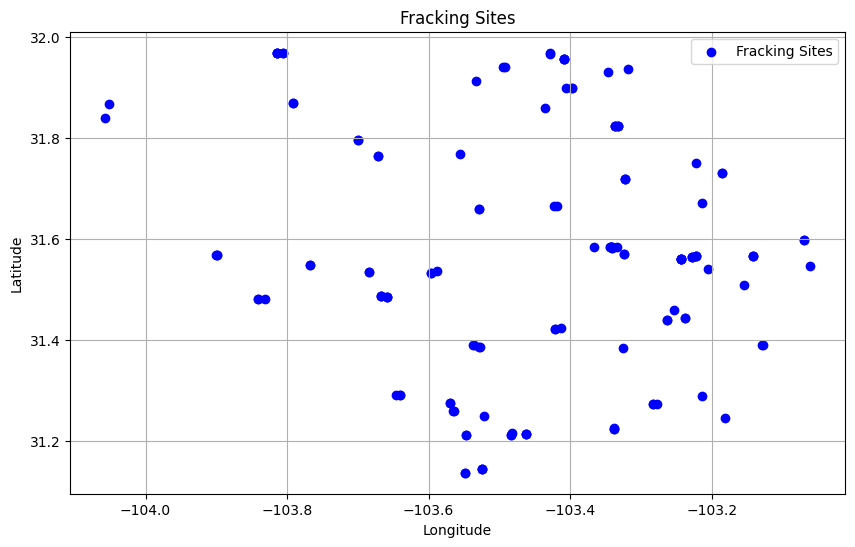

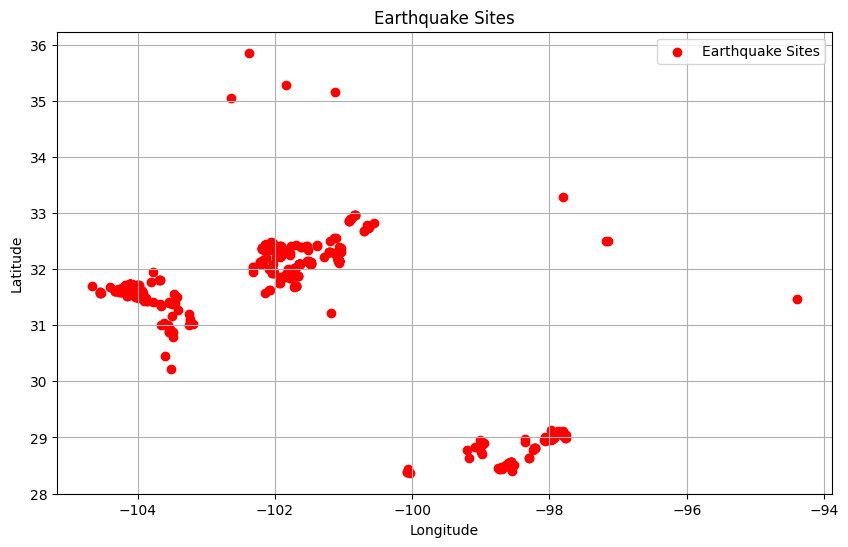

In [32]:
import matplotlib.pyplot as plt

# Extract fracking site coordinates
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites')
plt.grid(True)
plt.legend()  # Show the legend
plt.show()

eq_lats = [eq['Lat'] for eq in earthquake_data]
eq_lons = [eq['Long'] for eq in earthquake_data]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Sites')
plt.grid(True)
plt.legend()  # Show the legend
plt.show()


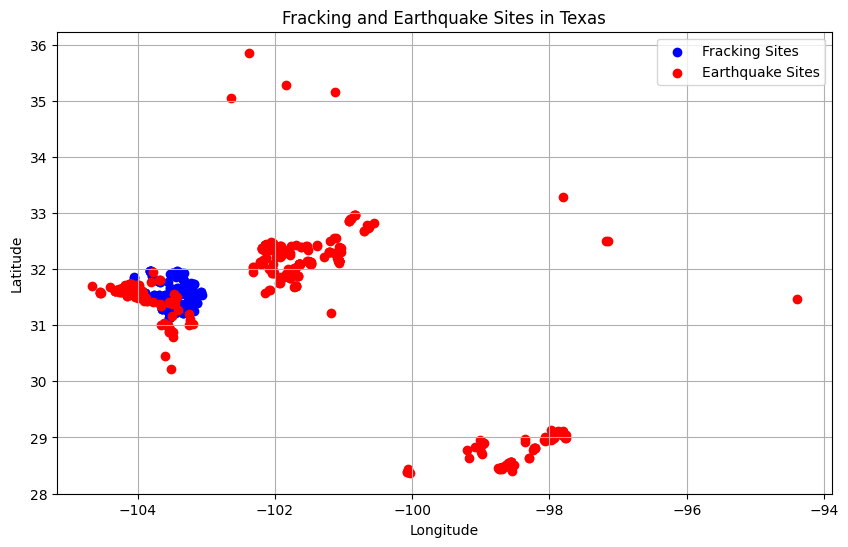

In [31]:
import matplotlib.pyplot as plt

# Fracking data (assuming you have it in fracking_df)
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

# Earthquake data (assuming you have it in earthquake_data)
eq_lats = [eq['Lat'] for eq in earthquake_data]
eq_lons = [eq['Long'] for eq in earthquake_data]

plt.figure(figsize=(10, 6))

# Plot fracking sites
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

# Plot earthquake sites
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas')
plt.grid(True)
plt.legend()  # Show the legend
plt.show()

In [6]:
from geopy import distance
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance.distance(newport_ri, cleveland_oh).km)

866.4554329098685


In [6]:
import pyproj

# Define the source and target coordinate systems
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

# Create a transformer object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

# Define the input coordinates
latitude = 31.2137
longitude = -103.4621

# Perform the transformation
latitude_wgs84, longitude_wgs84 = transformer.transform(latitude, longitude)

# Print the transformed coordinates
print(f"WGS84 Latitude: {latitude_wgs84}")
print(f"WGS84 Longitude: {longitude_wgs84}")

WGS84 Latitude: 31.2137
WGS84 Longitude: -103.4621
